## COLMAP OUTPUT

In [140]:
import numpy as np
import plotly.graph_objects as go

def load_points3D_txt(path):
    pts, colors = [], []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip(): 
                continue
            vals = line.strip().split()
            x, y, z = map(float, vals[1:4])
            r, g, b = map(int, vals[4:7])
            pts.append([x, y, z])
            colors.append(f'rgb({r},{g},{b})')
    return np.array(pts), colors

points3D_path = "/home/sairam/NU/AFR/HW4/buddha/sparse/0/points3D.txt"
pts, colors = load_points3D_txt(points3D_path)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=pts[:,0], y=pts[:,1], z=pts[:,2],
    mode='markers',
    marker=dict(size=2, color=colors, opacity=0.8)
))
fig.update_layout(scene=dict(aspectmode='data'),
                  title="COLMAP OUTPUT",
                  width=900, height=700)
fig.show()

# My SFM PIPELINE!

In [141]:
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import gtsam
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# Tunable Parameters

RATIO_TEST = 0.75 # BF Lowe's Ratio
MIN_MATCHES = 40           
RANSAC_ITERS = 3000
RANSAC_THRESH_PX = 2.0          
MIN_PARALLAX_DEG = 0.7          
REPROJ_THRESH_PX = 4.0          
MAX_PAIR_GAP = 4
MIN_PNP_INLIERS = 25    

## Loading and Enhancing Images

In [142]:
img_dir = "/home/sairam/NU/AFR/HW4/buddha/buddha_images"
colmap_sparse_dir = "/home/sairam/NU/AFR/HW4/buddha/sparse/0"

img_paths = sorted(glob.glob(os.path.join(img_dir, "*")))
imgs = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for p in img_paths:
    im = cv2.imread(p)
    if im is None: 
        continue
    g = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    g = clahe.apply(g)
    imgs.append(g)

N = len(imgs)
print("Total images loaded:", N)


Total images loaded: 24


## Camera Intrinsics

Reading the cameras.txt from COLMAP output to extract
- Camera intrinsic matrix K
- Radial distortion coefficient k1  

In [143]:
def load_single_camera_intrinsics(cameras_txt):
    with open(cameras_txt, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith('#'): 
                continue
            p = line.split()
            model = p[1]
            if model != "SIMPLE_RADIAL":
                raise NotImplementedError(f"Model {model} not handled")
            fval, cx, cy, k1 = map(float, p[4:8])
            K = np.array([[fval, 0,   cx],
                          [0,    fval, cy],
                          [0,    0,    1.0]], dtype=float)
            return K, k1
    raise RuntimeError("No camera line found in cameras.txt")

K, k1 = load_single_camera_intrinsics(os.path.join(colmap_sparse_dir, "cameras.txt"))
print("Camera Intrinsic Matrix, K:\n", K)
print("\nRadial Distortion Coefficient, k1:", k1)


Camera Intrinsic Matrix, K:
 [[1658.175    0.     540.   ]
 [   0.    1658.175  960.   ]
 [   0.       0.       1.   ]]

Radial Distortion Coefficient, k1: 0.007408448970193367


## SIFT and BF

Initializing SIFT and Brute-Force Matcher

In [144]:
sift = cv2.SIFT_create()
bf   = cv2.BFMatcher()

## HELPER FUNCTIONS

#### **Correcting Radial Distortion -**
- **undistort_points_simple_radial()**: Corrects the Radial lens distortion (if any!) for all keypoints using the distortion coefficient from the camera intrinsics.

#### **Fundamental Matrix -**
- **normalize_points()**: Normalizing the 2D points for numerical stability in 8-point SVD algorithm.

- **eight_point_F()**: Computes the Fundamental matrix F b/w two views using the 8-point algorithm. 

- **sampson_error()**: Computes the sampson distance, an approximation of the geometric reprojection error for evaluating how well the 2D points satisfy epipolar constraints.

- **F_Matrix()**: Estimates the best Fundamental matrix F by using RANSAC. Repeatedly samples F, ans selects the model with most inliers (lowest sampson error).

#### **Estimating Camera Pose from Essential Matrix -**
- **decompose_E()**: Decomposes the Essential Matrix into four possible (R,t) combinations representing the relative pose b/w 2 cameras. 

- **triangulate_linear()**: Performs linear triangulation to get 3D point positions intersecting 2 camera ray views corresponding to each image correspondence.

- **baseline_parallax()**: Calculates median angular parallax b/w rays to ensure sufficient baseline for stable triangulation.

- **correct_pose()**: Tests for all four Transformations from the decomposition of the Essential matrix E, triangulates for each and selects the (R,t) with positive depth (z>0 i.e; infront of the cameras) and suffcient parallax (baseline).

In [145]:
def undistort_points_simple_radial(pts, K, k1):
    dist = np.array([k1,0,0,0,0], float)
    pts_ud = cv2.undistortPoints(pts.reshape(-1,1,2), K, dist, P=K)
    return pts_ud.reshape(-1,2)

def normalize_points(pts):
    c = pts.mean(axis=0)
    d = np.sqrt(((pts - c)**2).sum(axis=1)).mean()
    s = np.sqrt(2.0) / (d + 1e-12)
    T = np.array([[s,0,-s*c[0]],[0,s,-s*c[1]],[0,0,1]], float)
    pts_h = np.hstack([pts, np.ones((len(pts),1))])
    pts_n = (T @ pts_h.T).T[:, :2]
    return pts_n, T

def eight_point_F(pts1, pts2):
    p1n, T1 = normalize_points(pts1)
    p2n, T2 = normalize_points(pts2)
    x1,y1 = p1n[:,0], p1n[:,1]
    x2,y2 = p2n[:,0], p2n[:,1]
    A = np.stack([x2*x1, x2*y1, x2,
                  y2*x1, y2*y1, y2,
                  x1,     y1,    np.ones_like(x1)], axis=1)
    _,_,Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3,3)
    U,S,Vt = np.linalg.svd(F)
    S[-1] = 0.0
    F = U @ np.diag(S) @ Vt
    F = T2.T @ F @ T1
    return F / (F[-1,-1] + 1e-12)

def sampson_error(F, x1, x2):
    x1h = np.hstack([x1, np.ones((len(x1),1))])
    x2h = np.hstack([x2, np.ones((len(x2),1))])
    Fx1  = (F  @ x1h.T).T
    Ftx2 = (F.T@ x2h.T).T
    num = np.sum(x2h * Fx1, axis=1)**2
    den = Fx1[:,0]**2 + Fx1[:,1]**2 + Ftx2[:,0]**2 + Ftx2[:,1]**2 + 1e-12
    return num / den

def F_Matrix(pts1, pts2, iters=RANSAC_ITERS, thresh_px=RANSAC_THRESH_PX, seed=0):
    N = len(pts1)
    rng = np.random.default_rng(seed)
    best_F, best_inl, best_cnt = None, None, -1
    if N < 8: 
        return None, None
    for _ in range(iters):
        I = rng.choice(N, 8, replace=False)
        F = eight_point_F(pts1[I], pts2[I])
        e = sampson_error(F, pts1, pts2)
        inl = e < (thresh_px**2)
        cnt = int(inl.sum())
        if cnt > best_cnt:
            best_cnt, best_F, best_inl = cnt, F, inl
    if best_inl is None or best_cnt < 8:
        return None, None
    F_ref = eight_point_F(pts1[best_inl], pts2[best_inl])
    return F_ref, best_inl

def decompose_E(E):
    U, S, Vt = np.linalg.svd(E)
    if np.linalg.det(U @ Vt) < 0: 
        Vt = -Vt
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]], float)
    R1 = U @ W  @ Vt
    R2 = U @ W.T @ Vt
    t  = U[:,2]
    return [(R1, t), (R1,-t), (R2, t), (R2,-t)]

def triangulate_linear(P1, P2, pts1, pts2):
    X = np.zeros((len(pts1),3), float)
    for i,(x1,y1,x2,y2) in enumerate(np.hstack([pts1, pts2])):
        A = np.vstack([
            x1*P1[2]-P1[0],
            y1*P1[2]-P1[1],
            x2*P2[2]-P2[0],
            y2*P2[2]-P2[1],
        ])
        _,_,Vt = np.linalg.svd(A)
        Xh = Vt[-1]
        X[i] = Xh[:3] / (Xh[3] + 1e-12)
    return X

def baseline_parallax(R, t, K1, K2, pts1, pts2):
    v1 = (np.linalg.inv(K1) @ np.hstack([pts1, np.ones((len(pts1),1))]).T).T
    v2 = (np.linalg.inv(K2) @ np.hstack([pts2, np.ones((len(pts2),1))]).T).T
    v1 = v1 / (np.linalg.norm(v1, axis=1, keepdims=True)+1e-12)
    v2_cam1 = (R.T @ v2.T).T
    v2_cam1 = v2_cam1 / (np.linalg.norm(v2_cam1, axis=1, keepdims=True)+1e-12)
    cosang = np.clip(np.sum(v1*v2_cam1, axis=1), -1, 1)
    return np.median(np.degrees(np.arccos(cosang)))

def correct_pose(E, K1, K2, pts1, pts2, min_deg=MIN_PARALLAX_DEG):
    P1 = K1 @ np.hstack([np.eye(3), np.zeros((3,1))])
    best, best_X, best_p1, best_p2, best_score = None, None, None, None, -1
    for R, t in decompose_E(E):
        P2 = K2 @ np.hstack([R, t.reshape(3,1)])
        X  = triangulate_linear(P1, P2, pts1, pts2)
        X2 = (R @ X.T + t.reshape(3,1)).T
        front = (X[:,2] > 0) & (X2[:,2] > 0)
        if front.sum() < 20:
            continue
        par = baseline_parallax(R, t, K1, K2, pts1[front], pts2[front])
        score = front.sum() + 15.0*par
        if par >= min_deg and score > best_score:
            best      = (R, t)
            best_X    = X[front]
            best_p1   = pts1[front]
            best_p2   = pts2[front]
            best_score= score
    if best is None:
        return None, None, None, None
    return best, best_X, best_p1, best_p2

def reprojection_errors(P, X, pts):
    Xh = np.hstack([X, np.ones((len(X),1))])
    uvh = (P @ Xh.T).T
    uv  = uvh[:,:2] / (uvh[:,2:3] + 1e-12)
    return np.linalg.norm(uv - pts, axis=1)


## Feature Extraction and Pairwise (Image pairs) Epipolar matching

Finding Keypoints and descriptors for all Images, and perform pairwise matching with neighbors (in a MAX_PAIR_GAP window), and RANSAC filtering to establish all reliable pairs (> MIN_MATCHES)

In [146]:
kps, des = [], []
for g in imgs:
    k, d = sift.detectAndCompute(g, None)
    kps.append(k); des.append(d)

pair_matches = {}
pairs_for_tracks = []

for i in range(N-1):
    for j in range(i+1, min(N, i+1+MAX_PAIR_GAP)):
        if des[i] is None or des[j] is None: 
            continue

        knn = bf.knnMatch(des[i], des[j], k=2)
        good = [a for a,b in knn if a.distance < RATIO_TEST*b.distance]
        if len(good) < MIN_MATCHES:
            continue

        pts_i = np.float32([kps[i][g.queryIdx].pt for g in good])
        pts_j = np.float32([kps[j][g.trainIdx].pt for g in good])

        p1u = undistort_points_simple_radial(pts_i, K, k1)
        p2u = undistort_points_simple_radial(pts_j, K, k1)

        F, inl = F_Matrix(p1u, p2u, iters=RANSAC_ITERS, thresh_px=RANSAC_THRESH_PX)
        if F is None or inl.sum() < MIN_MATCHES:
            continue

        keep  = np.where(inl)[0]
        idx_i = np.array([good[t].queryIdx for t in keep], dtype=int)
        idx_j = np.array([good[t].trainIdx for t in keep], dtype=int)

        E = K.T @ F @ K

        pair_matches[(i,j)] = dict(
            E=E,
            p1u=p1u[inl],
            p2u=p2u[inl],
            idx_i=idx_i,
            idx_j=idx_j
        )
        pairs_for_tracks.append((i, j, idx_i, idx_j))
        print(f"Pair {i}-{j}: stored with {int(inl.sum())} inliers")

print("Total stored pairs:", len(pair_matches))


Pair 0-1: stored with 890 inliers
Pair 0-2: stored with 362 inliers
Pair 0-3: stored with 282 inliers
Pair 0-4: stored with 152 inliers
Pair 1-2: stored with 438 inliers
Pair 1-3: stored with 325 inliers
Pair 1-4: stored with 203 inliers
Pair 1-5: stored with 114 inliers
Pair 2-3: stored with 405 inliers
Pair 2-4: stored with 196 inliers
Pair 2-5: stored with 105 inliers
Pair 2-6: stored with 78 inliers
Pair 3-4: stored with 182 inliers
Pair 3-5: stored with 124 inliers
Pair 3-6: stored with 67 inliers
Pair 4-5: stored with 202 inliers
Pair 4-6: stored with 122 inliers
Pair 4-7: stored with 55 inliers
Pair 5-6: stored with 290 inliers
Pair 5-7: stored with 156 inliers
Pair 5-8: stored with 83 inliers
Pair 6-7: stored with 278 inliers
Pair 6-8: stored with 124 inliers
Pair 6-9: stored with 58 inliers
Pair 7-8: stored with 170 inliers
Pair 7-9: stored with 87 inliers
Pair 7-10: stored with 53 inliers
Pair 8-9: stored with 237 inliers
Pair 8-10: stored with 127 inliers
Pair 8-11: stored w

## Seed pair selection and initial 3D reconstruction

Identifying the best image pair (best seed) from the matched pairs, to initialize the SFM reconstruction and build the initial 3D structure from the best seed

In [147]:
best_seed = None
best_count = -1
for (i, j), D in pair_matches.items():
    E   = D["E"]
    p1u = D["p1u"]
    p2u = D["p2u"]
    Rt, X, p1p, p2p = correct_pose(E, K, K, p1u, p2u, min_deg=MIN_PARALLAX_DEG)
    if Rt is None: 
        continue
    if len(X) > best_count:
        best_seed = (i, j, Rt, X)
        best_count = len(X)

if best_seed is None:
    raise RuntimeError("Could not find a valid seed pair. Lower MIN_PARALLAX_DEG / RANSAC_THRESH_PX.")

i0, j0, (R_seed, t_seed), X_seed = best_seed
print(f"Seed = {i0}-{j0} with {best_count} points")

camera_poses = {i0: (np.eye(3), np.zeros((3,1)))}
camera_poses[j0] = (R_seed, t_seed.reshape(3,1))
cloud_chunks = [X_seed]

Seed = 20-21 with 408 points


## Feature Tracks using Union-Find

Reference paper (UNORDERED FEATURE TRACKING): https://imagine.enpc.fr/~moulonp/publis/featureTracking_CVMP12.pdf

I am adopting the Union–Find based multi-view track fusion method to efficiently merge all pairwise correspondences into globally consistent feature tracks.

In [148]:
''' Each (image, keypoint) is treated as a node'''
node_id = {}
rev = [] # reverse index to map the node id
for i in range(N):
    for ki in range(len(kps[i])):
        node_id[(i, ki)] = len(rev)
        rev.append((i, ki))

''' Union-Find Structure'''
parent = np.arange(len(rev))
rank = np.zeros(len(rev), dtype=int)

def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x

''' union() merges nodes that represents the same physical features
    mathced across image pairs'''
def union(a,b):
    ra, rb = find(a), find(b)
    if ra == rb: return
    if rank[ra] < rank[rb]: parent[ra] = rb
    elif rank[ra] > rank[rb]: parent[rb] = ra
    else: parent[rb] = ra; rank[ra] += 1

''' For every pairwise feature match, it unions the two keypoints
                
                "join(a,b) = union(find(a), find(b))"
'''
for i, j, ii, jj in pairs_for_tracks:
    for a, b in zip(ii, jj):
        union(node_id[(i, a)], node_id[(j, b)])

''' After akl unions, now we have to perform find() to group all
    connected nodes, each resulting set becomes a feature track'''
tracks = {}
for nid, (im, ki) in enumerate(rev):
    r = find(nid)
    tracks.setdefault(r, []).append((im, ki))

tracks = {tid: obs for tid, obs in tracks.items() if len(obs) >= 2}

''' A look up for mapping each image's keypoint index to its 
    corresponding track ID'''
img_kp_to_tid = [dict() for _ in range(N)]
for tid, obs in tracks.items():
    for (im, ki) in obs:
        img_kp_to_tid[im][ki] = tid
        
''' Converting every keypoint's pixel location to its undistorted version '''
img_uv = []
for i in range(N):
    if len(kps[i]) == 0:
        img_uv.append(np.empty((0,2), dtype=np.float32))
        continue
    pts = np.float32([kp.pt for kp in kps[i]])
    img_uv.append(undistort_points_simple_radial(pts, K, k1))

In [149]:
''' Locating the seed pair. '''
seed_match = next(((ii, jj) for (a, b, ii, jj) in pairs_for_tracks if a == i0 and b == j0), None)

ii_seed, jj_seed = seed_match
p1_seed = img_uv[i0][ii_seed]
p2_seed = img_uv[j0][jj_seed]

''' Recomputing F on seed to ensure consistency in filtered inliers used 
    in 'correct_pose(), to get Pose (R,t) along with triangulated points
    for the seed pair. '''
F_seed, inl_seed = F_Matrix(p1_seed, p2_seed, iters=RANSAC_ITERS, thresh_px=RANSAC_THRESH_PX)
E_seed = K.T @ F_seed @ K
(Rs, ts), X_seed_filtered, p1f, p2f = correct_pose(E_seed, K, K, p1_seed[inl_seed], p2_seed[inl_seed], min_deg=MIN_PARALLAX_DEG)

''' Maps filtered undistorted keypoints back to the kp
    (original SIFT keypoints)indices. '''
def nearest_index(ref_uv, query_uv):
    d = np.linalg.norm(ref_uv - query_uv, axis=1)
    return int(np.argmin(d))

''' Finding which original keypoints correspond to triangulated 3D points'''
seed_idx_i = []
seed_idx_j = []
ref_i = p1_seed[inl_seed]
ref_j = p2_seed[inl_seed]
for a in p1f:
    k = nearest_index(ref_i, a)
    seed_idx_i.append(int(ii_seed[inl_seed][k]))
for b in p2f:
    k = nearest_index(ref_j, b)
    seed_idx_j.append(int(jj_seed[inl_seed][k]))
seed_idx_i = np.array(seed_idx_i, dtype=int)
seed_idx_j = np.array(seed_idx_j, dtype=int)

''' Linkin the 3D Landmark coordinates to the multi-view tracks'''
track_xyz = {}
for ki, kj, X in zip(seed_idx_i, seed_idx_j, X_seed_filtered):
    tid_i = img_kp_to_tid[i0].get(ki, None)
    tid_j = img_kp_to_tid[j0].get(kj, None)
    if tid_i is not None and tid_j is not None and tid_i == tid_j:
        track_xyz[tid_i] = X


## Camera Registration via PnP

Incrementally registering new camera views into the existing 3D reconstruction (just the seed initially) by estimating their poses (R,t) relative to the seed pair map.

In [150]:
def neighbors(i, gap=MAX_PAIR_GAP):
    return [j for j in range(max(0, i-gap), min(N, i+gap+1)) if j != i]

''' Registering new image by using Perspective-n-point (PnP) problem.
    using cv2.solvePnPRansac() to get (R,t)'''

def PnP(view):
    """Register 'view' with PnP using any 2D - 3D correspondences found in tracks."""
    if view in camera_poses:
        return True
    pts3d, pts2d = [], []
    for ki, tid in img_kp_to_tid[view].items():
        if tid in track_xyz:
            pts3d.append(track_xyz[tid])          
            pts2d.append(img_uv[view][ki])        
    if len(pts3d) < 6:
        return False
    pts3d = np.asarray(pts3d, np.float32)
    pts2d = np.asarray(pts2d, np.float32)
    ok, R_Pnp, t_PnP, inl = cv2.solvePnPRansac(
        pts3d, pts2d, K, None,
        flags=cv2.SOLVEPNP_ITERATIVE,
        reprojectionError=REPROJ_THRESH_PX,
        iterationsCount=300
    )
    if not ok or inl is None or len(inl) < MIN_PNP_INLIERS:
        return False
    R,_ = cv2.Rodrigues(R_Pnp)
    camera_poses[view] = (R, t_PnP.reshape(3,1))
    return True



I tried using this function block for registering new views, but this was causing scale drift and burst of unstable 3D points and camera centers. Hence, I shifted to PnP approach


In [151]:
# def register_with_E(i, j):
#     """Register j relative to already-registered i, then scale t using overlap with map."""
#     if j in camera_poses:
#         return True
#     # find the (i,j) pair record
#     match = next(((ii,jj) for (a,b,ii,jj) in pairs_for_tracks if a==i and b==j), None)
#     if match is None:
#         return False
#     ii, jj   = match
#     p1u      = img_uv[i][ii]
#     p2u      = img_uv[j][jj]
#     F, inl   = F_Matrix(p1u, p2u, iters=RANSAC_ITERS, thresh_px=RANSAC_THRESH_PX)
#     if F is None or inl.sum() < 40:
#         return False
#     E = K.T @ F @ K
#     Rt, Xij, q1, q2 = correct_pose(E, K, K, p1u[inl], p2u[inl], min_deg=MIN_PARALLAX_DEG)
#     if Rt is None:
#         return False
#     R_rel, t_rel = Rt

#     Ri, ti = camera_poses[i]
#     P_i    = K @ np.hstack([np.eye(3), np.zeros((3,1))])
#     P_jrel = K @ np.hstack([R_rel, t_rel.reshape(3,1)])
#     X_unscaled = triangulate_linear(P_i, P_jrel, q1, q2)

#     A, B = [], [] 
#     ref_i = p1u[inl]
#     for uv_i, Xi_cam in zip(q1, X_unscaled):
#         k = np.argmin(np.linalg.norm(ref_i - uv_i, axis=1))
#         kp_idx_i = ii[inl][k]
#         tid = img_kp_to_tid[i].get(int(kp_idx_i), None)
#         if tid is None or tid not in track_xyz:
#             continue
#         Xw_from_i = (Ri.T @ (Xi_cam - ti.ravel())).ravel()  # cam->world
#         A.append(Xw_from_i)
#         B.append(track_xyz[tid])
#     if len(A) < 6:
#         return False

#     s, _, _ = umeyama_similarity(np.asarray(A), np.asarray(B))
#     t_rel = s * t_rel

#     # compose world→cam for j
#     Rj = R_rel @ Ri
#     tj = R_rel @ ti + t_rel.reshape(3,1)
#     camera_poses[j] = (Rj, tj)
#     return True

# ''' Computing similarity transform (scale, rotation, translation) aligning two 3D
#     point sets using the Umeyama method (We Only need scale for this implementation)'''

# def umeyama_similarity(A, B):
#     A = np.asarray(A, float); B = np.asarray(B, float)
#     muA, muB = A.mean(0), B.mean(0)
#     X, Y = A - muA, B - muB
#     U,S,Vt = np.linalg.svd((Y.T @ X)/len(A))
#     R = U @ Vt
#     if np.linalg.det(R) < 0: Vt[-1] *= -1; R = U @ Vt
#     var = (X*X).sum()/len(A)
#     s = np.trace(np.diag(S)) / (var + 1e-12)
#     t = muB - s*(R@muA)
#     return s, R, t

## PnP + Triangulation

In [152]:
''' PnP estimates each new camera pose for the known 3D - 2D.
    Triangulation add new 3D points observed by overlapping cameras.
    Doing both until all camera views (24 in our case) are registered. '''

registered = set(camera_poses.keys())
frontier   = list(registered) # BFS queue
cloud_chunks = [X_seed_filtered] # reconstructed 3D points so far

def triangulate_shared(i, j):
    """Triangulate new tracks that appear in both i and j but are not yet 3D."""
    Ri, ti = camera_poses[i]
    Rj, tj = camera_poses[j]
    P_i = K @ np.hstack([Ri, ti])
    P_j = K @ np.hstack([Rj, tj])

    shared = []
    for ki, tid in img_kp_to_tid[i].items():
        if tid in track_xyz:
            continue

        for (im, kj) in tracks[tid]:
            if im == j:
                shared.append((tid, ki, kj))
                break
    if not shared:
        return

    pts_i = np.float32([img_uv[i][ka] for (_,ka,_) in shared])
    pts_j = np.float32([img_uv[j][kb] for (_,_,kb) in shared])

    X = triangulate_linear(P_i, P_j, pts_i, pts_j)
    Xi = (Ri @ X.T + ti).T
    Xj = (Rj @ X.T + tj).T
    front = (Xi[:,2] > 0) & (Xj[:,2] > 0)
    if front.sum() == 0:
        return

    e1 = reprojection_errors(P_i, X[front], pts_i[front])
    e2 = reprojection_errors(P_j, X[front], pts_j[front])
    keep = (e1 < REPROJ_THRESH_PX) & (e2 < REPROJ_THRESH_PX)
    X_keep = X[front][keep]
    if len(X_keep) == 0:
        return

    cloud_chunks.append(X_keep)
    for (tid,_,_), Xw in zip(np.array(shared)[front][keep], X_keep):
        track_xyz[int(tid)] = Xw

while frontier:
    i = frontier.pop(0)
    for j in neighbors(i):
        if j in registered:
            continue
        ok = PnP(j)
        if ok:
            registered.add(j)
            frontier.append(j)
            triangulate_shared(i, j)

print(f"Registered {len(registered)}/{N} views")

Registered 24/24 views


## Visualizing the Result

In [153]:
''' Remove duplicates'''

if cloud_chunks:
    cloud = np.vstack([c for c in cloud_chunks if c is not None and c.size > 0])
    cloud = np.unique(np.round(cloud, 3), axis=0)
else:
    cloud = np.empty((0,3))

pose_items  = sorted(camera_poses.items(), key=lambda kv: kv[0])
cam_centers = np.array([(-R.T @ t).ravel() for _,(R,t) in pose_items])

print(f"Final: poses={len(cam_centers)}/{N}, points={len(cloud)}")

''' Normalize and recenter everything around the mean camera position'''

if len(cam_centers) >= 2:
    ctr = cam_centers.mean(0)
    cam_centers -= ctr
    cloud       -= ctr
    step = np.median(np.linalg.norm(np.diff(cam_centers, axis=0), axis=1)) if len(cam_centers)>1 else 1.0
    scl  = step if step > 1e-6 else 1.0
    cam_centers /= scl
    cloud       /= scl

Final: poses=24/24, points=2003


### Matplotlib viz

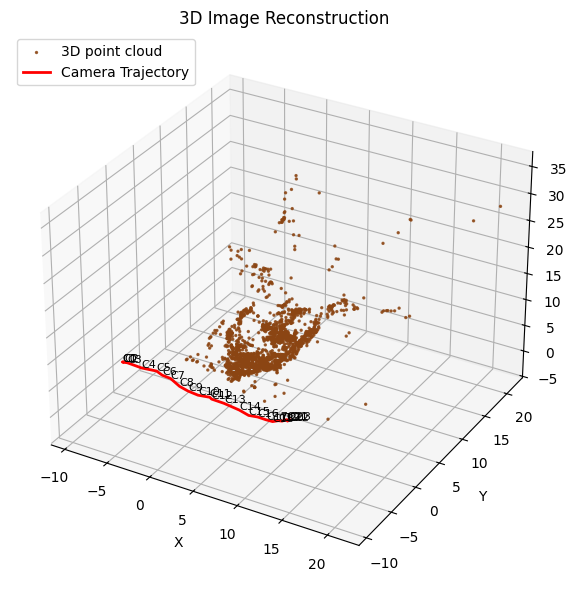

In [154]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

if len(cloud):
    ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2], s=2, c='saddlebrown', alpha=0.8, label='3D point cloud')

ax.plot(cam_centers[:,0], cam_centers[:,1], cam_centers[:,2], c='red', lw=2, label='Camera Trajectory')
for idx, c in enumerate(cam_centers):
    ax.text(c[0], c[1], c[2], f"C{pose_items[idx][0]}", color='k', fontsize=8)

ax.legend(loc='upper left')
ax.set_title("3D Image Reconstruction")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

### Plotly viz

In [155]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=cam_centers[:,0], y=cam_centers[:,1], z=cam_centers[:,2],
    mode='lines+markers+text',
    name='Camera Path',
    line=dict(color='blue', width=4),
    marker=dict(size=5, color='red'),
    text=[f"C{i}" for i in range(len(cam_centers))],
    textposition='top center'
))

fig.update_layout(
    title='Camera Trajectory',
    width=950, height=750,
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    legend=dict(x=0.02, y=0.98)
)

fig.show()

In [156]:
fig = go.Figure()

# 3D Point cloud
fig.add_trace(go.Scatter3d(
    x=cloud[:,0], y=cloud[:,1], z=cloud[:,2],
    mode='markers',
    name='3D Point cloud',
    marker=dict(size=2, color='saddlebrown', opacity=0.7)
))

# Camera Trajectory
fig.add_trace(go.Scatter3d(
    x=cam_centers[:,0], y=cam_centers[:,1], z=cam_centers[:,2],
    mode='lines+markers+text',
    name='Camera Trajectory',
    line=dict(color='blue', width=4),
    marker=dict(size=5, color='red'),
    text=[f"C{i}" for i in range(len(cam_centers))],
    textposition='top center'
))

fig.update_layout(
    title='3D Image Reconstruction',
    width=950, height=750,
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    legend=dict(x=0.02, y=0.98)
)

fig.show()

# GTSAM OPTIMIZATION!

In [157]:
obs_by_track = defaultdict(list)
for i in range(len(img_kp_to_tid)):
    if i >= len(img_uv) or img_uv[i] is None:
        continue
    for ki, tid in img_kp_to_tid[i].items():
        u, v = img_uv[i][ki]
        obs_by_track[tid].append((i, (float(u), float(v))))

In [158]:
''' Converting the stored world-to-camera transformation into camera
    pose in world coordinates for GTSAM Pose3 (Twc = cam in world) '''

def w2c_to_Twc(R_w2c, t_w2c):
    R_c2w = R_w2c.T
    t_c2w = -R_w2c.T @ t_w2c.reshape(3,)
    return gtsam.Pose3(gtsam.Rot3(R_c2w), gtsam.Point3(*t_c2w))

''' Converting the camera intrinsic matrix K into a GTSAM calibration object '''

def GTSAM_K(K):
    fx = float(K[0,0]); fy = float(K[1,1])
    cx = float(K[0,2]); cy = float(K[1,2])
    return gtsam.Cal3_S2(fx, fy, 0.0, cx, cy)

In [159]:
X = gtsam.symbol_shorthand.X # Camera poses
L = gtsam.symbol_shorthand.L # Landmarks (3D Points)

graph  = gtsam.NonlinearFactorGraph()
values = gtsam.Values()

Kmat = GTSAM_K(K)

''' Noise model for 2D reporjection errors. '''
measurement_noise = gtsam.noiseModel.Robust.Create(
                    gtsam.noiseModel.mEstimator.Huber.Create(1.0),
                    gtsam.noiseModel.Isotropic.Sigma(2, 1.0)
                    )

''' Adding a Pose3 prior to the first camera to fix global origin and orientation. '''
pose_prior = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.05,0.05,0.05, 0.01,0.01,0.01]))
first_key = min(camera_poses.keys())
R_w2c_0, t_w2c_0 = camera_poses[first_key]
Twc0 = w2c_to_Twc(R_w2c_0, t_w2c_0)
graph.add(gtsam.PriorFactorPose3(X(first_key), Twc0, pose_prior))

''' Adding a 3D point prior on one existing landmark to fix global scale. '''
scale_prior_added = False
point_prior_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.05)

for anchor_tid, Xw in (track_xyz.items() if isinstance(track_xyz, dict) else []):
    graph.add(gtsam.PriorFactorPoint3(L(anchor_tid), gtsam.Point3(*Xw), point_prior_noise))
    scale_prior_added = True
    break

In [160]:
''' Loading every known camera and 3D point to GTSAM '''

for i, (R_w2c, t_w2c) in camera_poses.items():
    Twc = w2c_to_Twc(R_w2c, t_w2c)
    values.insert(X(i), Twc.retract(1e-3*np.random.randn(6,1)))
    # Adding tiny jitter to help optimizer avoid singularities

if isinstance(track_xyz, dict):
    for tid, Xw in track_xyz.items():
        values.insert(L(tid), gtsam.Point3(*Xw))


In [161]:
''' connecting every observed 2D feature point in an image to its 
    corresponding 3D landmark in the world. '''

dded_obs = 0
used_tracks = 0
for tid, obs in obs_by_track.items():
    if tid not in track_xyz:
        continue
    if len(obs) < 2:
        continue
    used_tracks += 1
    for (i, (u, v)) in obs:
        if i not in camera_poses:
            continue
        z = gtsam.Point2(float(u), float(v))
        graph.add(gtsam.GenericProjectionFactorCal3_S2(z, measurement_noise, X(i), L(tid), Kmat))
        added_obs += 1

print(f"Added {used_tracks} tracks and {added_obs} measurements to graph.")
if not scale_prior_added:
    print("No landmark prior added ")

Added 2045 tracks and 26289 measurements to graph.


In [162]:
''' Adding explicit priors on the first two camera poses and one landmark to 
    fix the reference frame, orientation, and global scale of the reconstruction. '''

pose_prior = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.05, 0.05, 0.05, 0.01, 0.01, 0.01])
)
graph.add(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), pose_prior))

pose2_prior = gtsam.Pose3(
    gtsam.Rot3(),
    gtsam.Point3(1, 0, 0)
)
pose2_noise = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.1, 0.1, 0.1, 0.05, 0.05, 0.05])
)
graph.add(gtsam.PriorFactorPose3(X(1), pose2_prior, pose2_noise))

# adding a gentle landmark anchor just to prevent global drift
if len(track_xyz) > 0:
    first_tid = next(iter(track_xyz))
    first_point = track_xyz[first_tid]
    anchor_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.5)
    graph.add(
        gtsam.PriorFactorPoint3(L(first_tid),
                                gtsam.Point3(*first_point),
                                anchor_noise)
    )

In [163]:
''' Bundle Adjustment optimization using GTSAM's non-linear optimizer:
    Levenberg-Marquardt (LM) solver. '''
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, values, params)
result = optimizer.optimize()

init_error = graph.error(values)
final_error = graph.error(result)
improvement = 100 * (init_error - final_error) / init_error if init_error > 1e-6 else 0

print(f"Initial error: {init_error:.3f}")
print(f"Final error:   {final_error:.3f}")
print(f"Improvement:   {improvement:.2f}%")

''' RMS Reprojection Error '''
num_factors = graph.size()
rms_init = np.sqrt(init_error / num_factors)
rms_final = np.sqrt(final_error / num_factors)
print(f"\nRMS reprojection error: {rms_init:.3f}px → {rms_final:.3f}px")

''' Extracting the refined camera poses and 3D landmarks 
    back into w2c format for plotting.'''
optimized_camera_poses = {}
for i in camera_poses.keys():
    Twc = result.atPose3(X(i))
    R_c2w = np.array(Twc.rotation().matrix())
    t_c2w = np.array(Twc.translation())
    R_w2c = R_c2w.T
    t_w2c = (-R_c2w.T @ t_c2w).reshape(3,1)
    optimized_camera_poses[i] = (R_w2c, t_w2c)

optimized_points = {}
for tid, _ in obs_by_track.items():
    try:
        p = np.array(result.atPoint3(L(tid)))
        optimized_points[tid] = p

    except RuntimeError:
        pass

print(f"\nRecovered {len(optimized_camera_poses)} poses and {len(optimized_points)} landmarks.")

Initial error: 3533887.474
Final error:   1700053.542
Improvement:   51.89%

RMS reprojection error: 20.076px → 13.925px

Recovered 24 poses and 2045 landmarks.


In [164]:
optimized_points = []
for tid in track_xyz.keys():
    if result.exists(L(tid)):
        Pw = np.array(result.atPoint3(L(tid)))
        optimized_points.append(Pw)
optimized_points = np.array(optimized_points)

optimized_cam_centers = []
for i in sorted(camera_poses.keys()):
    if result.exists(X(i)):
        pose = result.atPose3(X(i))
        R = pose.rotation().matrix()
        t = np.array(pose.translation())   # translation as numpy
        C = -R.T @ t                      # world camera center
        optimized_cam_centers.append(C)
optimized_cam_centers = np.array(optimized_cam_centers)

''' Normalizing '''
if len(optimized_points) > 0 and len(optimized_cam_centers) > 1:
    mean_center = optimized_points.mean(axis=0)
    optimized_points -= mean_center
    optimized_cam_centers -= mean_center

    scale = np.linalg.norm(np.ptp(optimized_cam_centers, axis=0)) / 10.0
    if scale > 1e-6:
        optimized_points /= scale
        optimized_cam_centers /= scale

In [165]:
if len(optimized_points) > 0:
    points_trace = go.Scatter3d(
        x=optimized_points[:, 0],
        y=optimized_points[:, 1],
        z=optimized_points[:, 2],
        mode="markers",
        marker=dict(size=1.5, color="saddlebrown", opacity=0.8),
        name="Optimized 3D Points"
    )
else:
    points_trace = None

if len(optimized_cam_centers) > 0:
    cams_trace = go.Scatter3d(
        x=optimized_cam_centers[:, 0],
        y=optimized_cam_centers[:, 1],
        z=optimized_cam_centers[:, 2],
        mode='lines+markers+text',
        marker=dict(size=4, color="red"),
        text=[f"C{i}" for i in range(len(optimized_cam_centers))],
        textposition='top center',
        line=dict(color="red", width=2),
        name="Camera Centers"
    )
else:
    cams_trace = None

traces = [t for t in [points_trace, cams_trace] if t is not None]
fig = go.Figure(data=traces)
fig.update_layout(
    title="3D Image Reconstruction GTSAM",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        aspectmode="data"
    ),
    showlegend=True,
    width=900, height=700
)
fig.show()
